# The Router Pattern: Building a Semantic Traffic Controller

**Goal:** Stop sending every user query to GPT-4. 

In this notebook, we build a **Semantic Router**—a lightweight BERT model that predicts *which* entities exist in a text before we extract them. This allows us to route traffic to cheaper, specialized engines (Regex, Libpostal, Spacy) instead of expensive LLMs.

### The Pipeline
1. **Tag Purification:** Solving the "Class Overlap" problem (e.g., Is "California" an Address or a Name?).
2. **Multi-Label Training:** Teaching a model to recognize multiple distinct intents simultaneously.
3. **Distillation:** Shrinking the model to 15MB for ultra-fast CPU inference.

In [21]:
import pandas as pd
from datasets import load_dataset, Dataset, DatasetDict
import os
import ast
import torch
from torch.nn import BCEWithLogitsLoss, MSELoss
from transformers import Trainer, TrainingArguments, AutoModelForSequenceClassification, AutoTokenizer, DataCollatorWithPadding
from sklearn.metrics import f1_score, precision_recall_fscore_support, confusion_matrix
import random
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

## Configuration

In [22]:
# Mac Optimization (Optional)
os.environ["PYTORCH_MPS_HIGH_WATERMARK_RATIO"] = "0.0"

MAX_SAMPLES = 5000
TEACHER_MODEL_NAME = "xlm-roberta-base"
TEACHER_OUTPUT_DIR = "./bert_router_standard"
STUDENT_MODEL_NAME = "google/bert_uncased_L-4_H-256_A-4" # TinyBERT
STUDENT_OUTPUT_DIR = "./tiny_router"
TRAIN_DATA_PATH = "multi_label_router_train.csv"

id2label = {0: "REGEX", 1: "ADDRESS", 2: "NER", 3: "TEMPORAL"}
label2id = {v: k for k, v in id2label.items()}
class_names = list(id2label.values())

## Phase 1: Data Preparation and Tag Purification

In [23]:
print("Fetching data from ai4privacy/pii-masking-65k...")
ds_pii = load_dataset("ai4privacy/pii-masking-65k", split="train", streaming=True)

Fetching data from ai4privacy/pii-masking-65k...


In [24]:
# === DEFINING THE BOUNDARIES ===
regex_tags = {
    'BIC', 'BITCOINADDRESS', 'CREDITCARDCVV', 'CREDITCARDNUMBER', 
    'EMAIL', 'ETHEREUMADDRESS', 'IBAN', 'IP', 'IPV4', 'IPV6', 
    'LITECOINADDRESS', 'MAC', 'MASKEDNUMBER', 'PHONEIMEI', 
    'PHONE_NUMBER', 'SSN', 'URL', 'USERAGENT', 'VEHICLEVIN', 'VEHICLEVRM'
}
address_tags = {
    'STREET', 'STREETADDRESS', 'SECONDARYADDRESS', 
    'CITY', 'COUNTY', 'STATE', 'ZIPCODE' 
}
ner_tags = {
    'FIRSTNAME', 'MIDDLENAME', 'LASTNAME', 
    'COMPANY_NAME', 'ACCOUNTNAME', 'USERNAME',
    'JOBTITLE', 'JOBAREA', 'JOBDESCRIPTOR'
}
temporal_tags = {
    'DATE',
    'TIME'
}

In [25]:
print("Generating Multi-Label Training Data...")

final_data = []
for i, x in enumerate(ds_pii):
    if i >= MAX_SAMPLES: 
        break
    row_tags = set(t.split('-')[1] for t in x['token_entity_labels'] if '-' in t)
    
    label_vector = [
        1.0 if not row_tags.isdisjoint(regex_tags) else 0.0, 
        1.0 if not row_tags.isdisjoint(address_tags) else 0.0, 
        1.0 if not row_tags.isdisjoint(ner_tags) else 0.0,
        1.0 if not row_tags.isdisjoint(temporal_tags) else 0.0
    ]

    if sum(label_vector) > 0:
        final_data.append({
            "text": x['unmasked_text'], 
            "labels": label_vector
        })

df = pd.DataFrame(final_data)
df.to_csv(TRAIN_DATA_PATH, index=False)

print(f"✅ Created {len(df)} multi-labeled rows.")
print(df.head())

Generating Multi-Label Training Data...
✅ Created 4644 multi-labeled rows.
                                                text                labels
0  Mr. Adolphus Reagan Ziemann, as a Central Prin...  [0.0, 0.0, 1.0, 0.0]
1  Hello Hannah, would you please investigate the...  [0.0, 0.0, 1.0, 0.0]
2  We also request a review of our policies with ...  [1.0, 0.0, 0.0, 0.0]
3  Dear Devan, a company-wide presentation is req...  [0.0, 0.0, 1.0, 1.0]
4  Miss Dolly, we would appreciate your assistanc...  [0.0, 0.0, 1.0, 0.0]


## Phase 2: Teacher Model Training

In [26]:
df = pd.read_csv(TRAIN_DATA_PATH)
if isinstance(df["labels"].iloc[0], str):
    df["labels"] = df["labels"].apply(ast.literal_eval)

full_dataset = Dataset.from_pandas(df)
train_split = full_dataset.train_test_split(test_size=0.2, seed=42)
test_split = train_split["test"].train_test_split(test_size=0.5, seed=42)

dataset = DatasetDict({
    "train": train_split["train"],
    "validation": test_split["train"],
    "test": test_split["test"]
})

In [27]:
teacher_tokenizer = AutoTokenizer.from_pretrained(TEACHER_MODEL_NAME)
teacher_model = AutoModelForSequenceClassification.from_pretrained(
    TEACHER_MODEL_NAME, 
    num_labels=len(id2label),
    id2label=id2label,
    label2id=label2id,
    problem_type="multi_label_classification"
)

def preprocess_function(examples):
    tokenized = teacher_tokenizer(examples["text"], truncation=True, max_length=128)
    tokenized["labels"] = examples["labels"]
    return tokenized

tokenized_datasets = dataset.map(
    preprocess_function, 
    batched=True, 
    remove_columns=dataset["train"].column_names
)

data_collator = DataCollatorWithPadding(tokenizer=teacher_tokenizer)

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/3715 [00:00<?, ? examples/s]

Map:   0%|          | 0/464 [00:00<?, ? examples/s]

Map:   0%|          | 0/465 [00:00<?, ? examples/s]

In [28]:
def compute_metrics(p):
    preds = (p.predictions > 0).astype(int) 
    labels = p.label_ids
    return {'f1': f1_score(labels, preds, average='macro')}

class StandardTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss = BCEWithLogitsLoss()(logits, labels.float())
        return (loss, outputs) if return_outputs else loss

training_args = TrainingArguments(
    output_dir=TEACHER_OUTPUT_DIR,
    learning_rate=2e-5,
    per_device_train_batch_size=16, 
    num_train_epochs=3,
    weight_decay=0.01,
    eval_strategy="epoch",  
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    logging_steps=50,
    no_cuda=False,
)

trainer = StandardTrainer(
    model=teacher_model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"], 
    tokenizer=teacher_tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()
trainer.save_model(TEACHER_OUTPUT_DIR)
teacher_tokenizer.save_pretrained(TEACHER_OUTPUT_DIR)

/var/folders/0h/lzq04n7x32d82_vzmqqh8whr0000gn/T/ipykernel_54719/204424354.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `StandardTrainer.__init__`. Use `processing_class` instead.
  trainer = StandardTrainer(
/Volumes/T9-MAC/Pini/LLM Sandbox/PythonBert/bert_try/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,F1
1,0.269100,0.167086,0.785796
2,0.080500,0.063631,0.978816
3,0.055800,0.051867,0.980948


/Volumes/T9-MAC/Pini/LLM Sandbox/PythonBert/bert_try/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Volumes/T9-MAC/Pini/LLM Sandbox/PythonBert/bert_try/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


('./bert_router_standard/tokenizer_config.json',
 './bert_router_standard/special_tokens_map.json',
 './bert_router_standard/tokenizer.json')

## Phase 3: Teacher Model Evaluation

In [29]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
teacher_model.to(device)
teacher_model.eval()

def predict(text, model, tokenizer):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=128).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    return torch.sigmoid(outputs.logits).squeeze().cpu().numpy()

def fmt_prob(p, is_match):
    color = "\033[92m" if is_match else "\033[91m"
    if p < 0.5 and not is_match: color = "\033[90m"
    return f"{color}{p:.0%}\033[0m"

print(f"{'TEXT':<40} | {' | '.join(class_names)}")
print("-" * 85)

for i in random.sample(range(len(dataset["test"])), 15):
    sample = dataset["test"][i]
    text, labels = sample['text'], sample['labels']
    preds = predict(text, teacher_model, teacher_tokenizer)
    
    row_str = f"{text[:37]+'...':<40} | "
    row_str += ' | '.join([fmt_prob(preds[j], labels[j]==1) for j in range(len(class_names))])
    print(row_str)

TEXT                                     | REGEX | ADDRESS | NER | TEMPORAL
-------------------------------------------------------------------------------------
Our Creative team is putting together... | 98% | 1% | 99% | 2%
For the purpose of procuring a munici... | 4% | 99% | 3% | 3%
Our cybersecurity team needs to verif... | 99% | 1% | 1% | 1%
We identified a new financial liabili... | 3% | 99% | 4% | 3%
Marguerite, please draft an agreement... | 3% | 3% | 99% | 4%
We need additional data anonymized da... | 100% | 1% | 1% | 1%
Sorry, the credit card number 9318639... | 99% | 1% | 1% | 1%
Dr. Schulist, kindly review the equit... | 1% | 97% | 95% | 4%
Our meeting with the Roob Group went ... | 5% | 2% | 99% | 3%
Can you get a quote for purchasing ne... | 98% | 98% | 1% | 2%
Regarding the legal issue tied to an ... | 99% | 1% | 1% | 1%
Ensure that the funds are available a... | 99% | 1% | 1% | 1%
The transit from bitcoin address 39KC... | 99% | 1% | 1% | 1%
Please ensure that any commu

Teacher Speed: 362.8 samples/sec


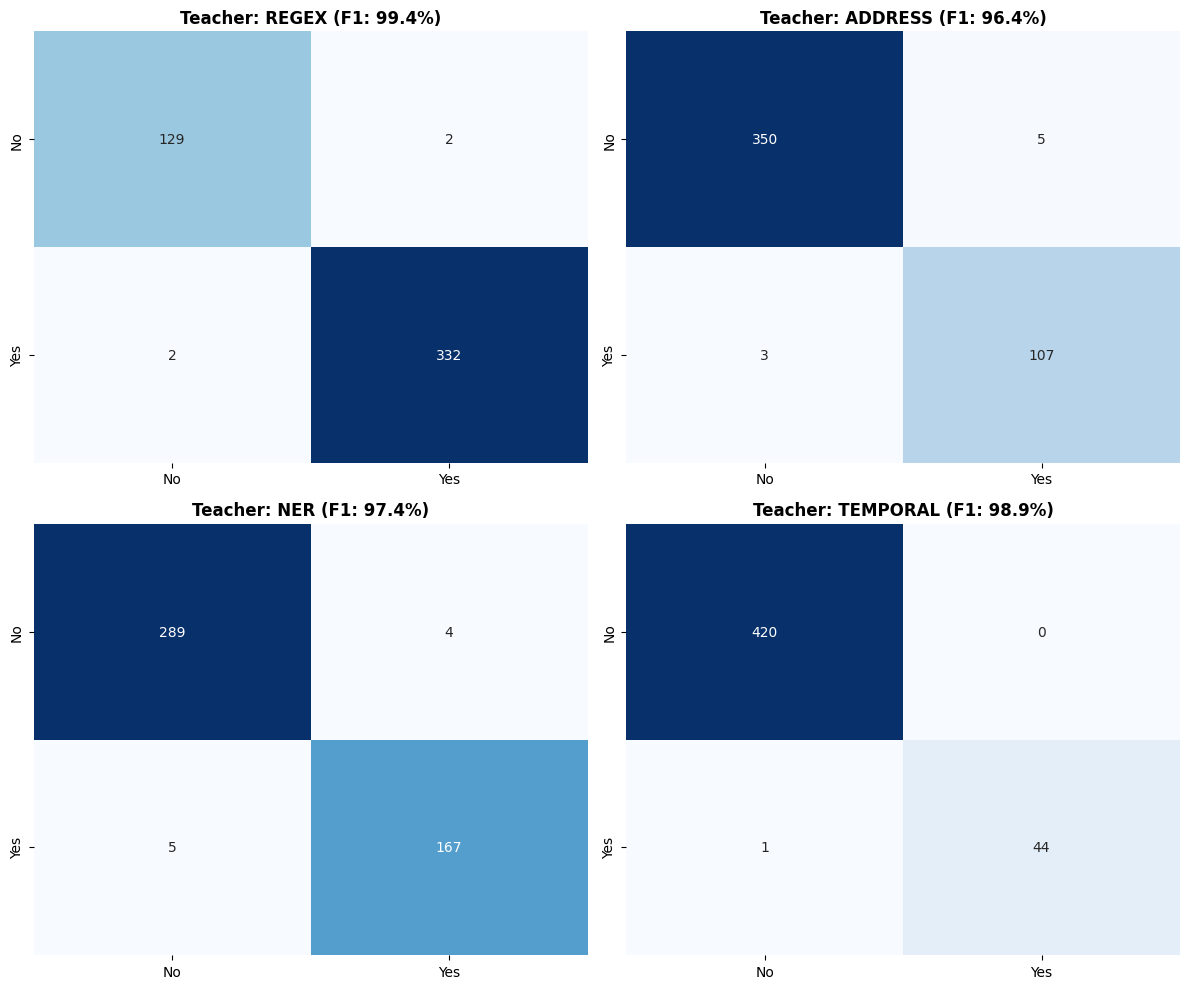

In [30]:
def evaluate_model(model, tokenizer, dataset_split, device):
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
    loader = DataLoader(dataset_split, batch_size=32, collate_fn=data_collator)
    
    model.eval()
    all_preds, all_labels = [], []
    
    start_time = time.time()
    with torch.no_grad():
        for batch in loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            labels = batch.pop("labels")
            outputs = model(**batch)
            preds = (torch.sigmoid(outputs.logits) > 0.5).int()
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    end_time = time.time()
    
    inference_time = end_time - start_time
    speed = len(dataset_split) / inference_time
    
    y_pred = np.vstack(all_preds)
    y_true = np.vstack(all_labels)
    
    metrics = []
    for i, name in enumerate(class_names):
        p, r, f1, _ = precision_recall_fscore_support(y_true[:, i], y_pred[:, i], average='binary', zero_division=0)
        metrics.append({"Class": name, "Precision": p, "Recall": r, "F1": f1})
        
    return y_true, y_pred, metrics, speed

teacher_true, teacher_pred, teacher_metrics, teacher_speed = evaluate_model(teacher_model, teacher_tokenizer, tokenized_datasets["test"], device)
print(f"Teacher Speed: {teacher_speed:.1f} samples/sec")

def plot_confusion_matrices(y_true, y_pred, class_names, model_name):
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()
    for i, label in enumerate(class_names):
        cm = confusion_matrix(y_true[:, i], y_pred[:, i], labels=[0, 1])
        f1 = f1_score(y_true[:, i], y_pred[:, i], average='binary')
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i], cbar=False,
                    xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
        axes[i].set_title(f"{model_name}: {label} (F1: {f1:.1%})", fontweight='bold')
    plt.tight_layout()
    plt.show()

plot_confusion_matrices(teacher_true, teacher_pred, class_names, "Teacher")

## Phase 4: Knowledge Distillation

In [31]:
print("Generating Teacher Logits for Distillation...")

def add_teacher_logits(batch):
    inputs = teacher_tokenizer(batch["text"], truncation=True, max_length=128, padding="max_length", return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = teacher_model(**inputs)
    return {"teacher_logits": outputs.logits.cpu().numpy()}

distill_dataset = dataset["train"].map(add_teacher_logits, batched=True, batch_size=32)

student_tokenizer = AutoTokenizer.from_pretrained(STUDENT_MODEL_NAME)
student_model = AutoModelForSequenceClassification.from_pretrained(
    STUDENT_MODEL_NAME, num_labels=len(id2label), id2label=id2label, label2id=label2id, problem_type="multi_label_classification"
)

Generating Teacher Logits for Distillation...


Map:   0%|          | 0/3715 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/bert_uncased_L-4_H-256_A-4 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [32]:
class DistillationTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        teacher_logits = inputs.pop("teacher_logits")
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        student_logits = outputs.logits
        
        loss_cls = BCEWithLogitsLoss()(student_logits, labels.float())
        loss_distill = MSELoss()(student_logits, teacher_logits)
        
        loss = (0.5 * loss_cls) + (0.5 * loss_distill)
        return (loss, outputs) if return_outputs else loss

def preprocess_student(examples):
    tokenized = student_tokenizer(examples["text"], truncation=True, max_length=128)
    tokenized["labels"] = examples["labels"]
    tokenized["teacher_logits"] = examples["teacher_logits"]
    return tokenized

tokenized_student_train = distill_dataset.map(preprocess_student, batched=True, remove_columns=distill_dataset.column_names)

class DistillCollator(DataCollatorWithPadding):
    def __call__(self, features):
        logits = [f.pop("teacher_logits") for f in features]
        batch = super().__call__(features)
        batch["teacher_logits"] = torch.tensor(logits)
        return batch

student_args = TrainingArguments(
    output_dir=STUDENT_OUTPUT_DIR,
    learning_rate=5e-5,
    per_device_train_batch_size=32,
    num_train_epochs=10,
    weight_decay=0.01,
    remove_unused_columns=False,
    no_cuda=False,
    logging_steps=100
)

distill_trainer = DistillationTrainer(
    model=student_model,
    args=student_args,
    train_dataset=tokenized_student_train,
    tokenizer=student_tokenizer,
    data_collator=DistillCollator(student_tokenizer)
)

print("Training Student...")
distill_trainer.train()

Map:   0%|          | 0/3715 [00:00<?, ? examples/s]

/var/folders/0h/lzq04n7x32d82_vzmqqh8whr0000gn/T/ipykernel_54719/3717799371.py:40: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `DistillationTrainer.__init__`. Use `processing_class` instead.
  distill_trainer = DistillationTrainer(
/Volumes/T9-MAC/Pini/LLM Sandbox/PythonBert/bert_try/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Training Student...


Step,Training Loss
100,6.537100
200,4.342500
300,3.061000
400,2.156000
500,1.666600
600,1.323700
700,1.031500
800,0.840200
900,0.728100
1000,0.660300


/Volumes/T9-MAC/Pini/LLM Sandbox/PythonBert/bert_try/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Volumes/T9-MAC/Pini/LLM Sandbox/PythonBert/bert_try/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=1170, training_loss=1.9969544467763005, metrics={'train_runtime': 36.37, 'train_samples_per_second': 1021.446, 'train_steps_per_second': 32.169, 'total_flos': 80305980002280.0, 'train_loss': 1.9969544467763005, 'epoch': 10.0})

## Phase 5: Student Model Evaluation and Comparison

Map:   0%|          | 0/465 [00:00<?, ? examples/s]

Student Speed: 3304.1 samples/sec


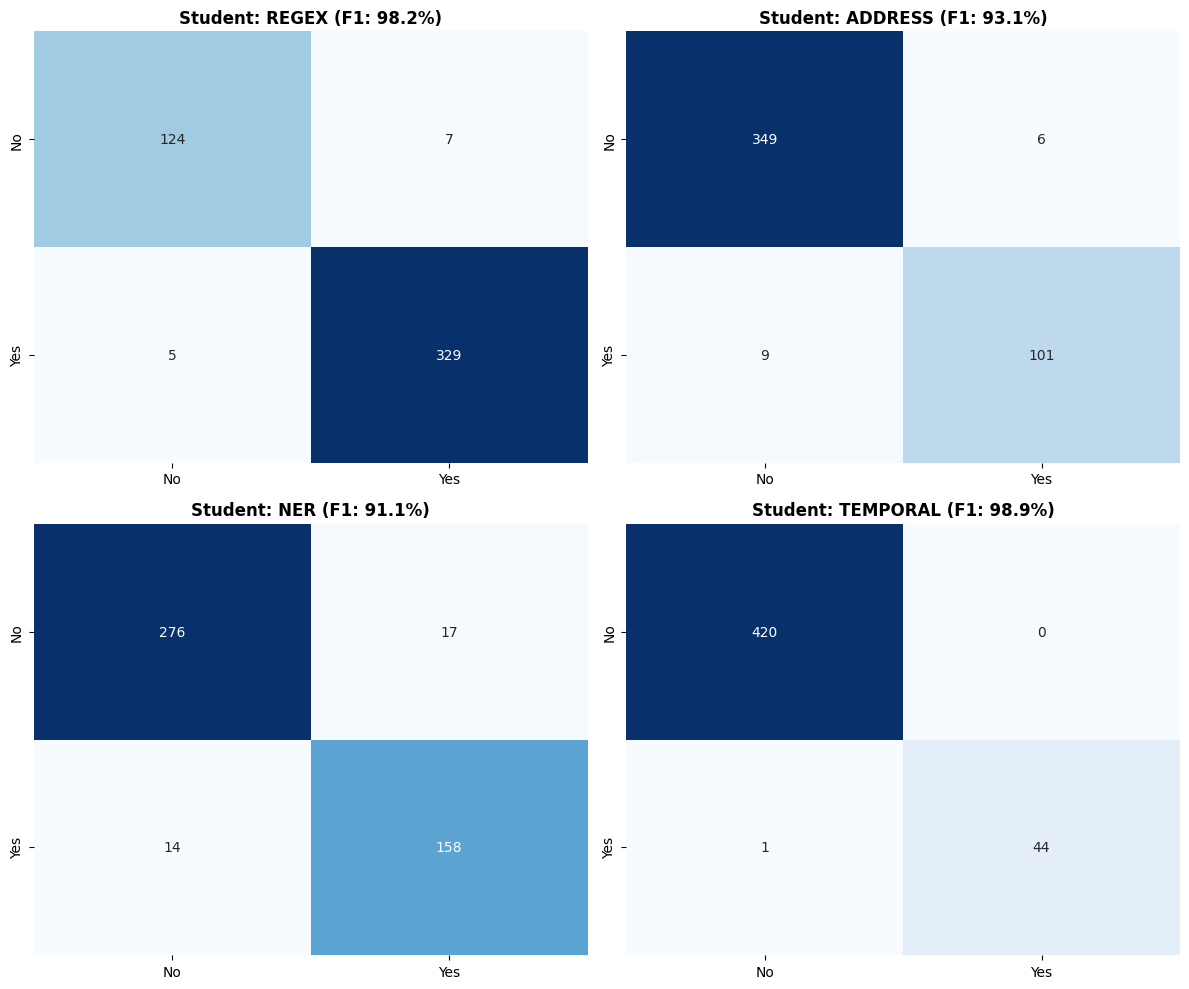

In [33]:
def prep_student_test(examples):
    return student_tokenizer(examples["text"], truncation=True, max_length=128)

tokenized_student_test = dataset["test"].map(prep_student_test, batched=True, remove_columns=['text'])

student_true, student_pred, student_metrics, student_speed = evaluate_model(student_model, student_tokenizer, tokenized_student_test, device)
print(f"Student Speed: {student_speed:.1f} samples/sec")

plot_confusion_matrices(student_true, student_pred, class_names, "Student")

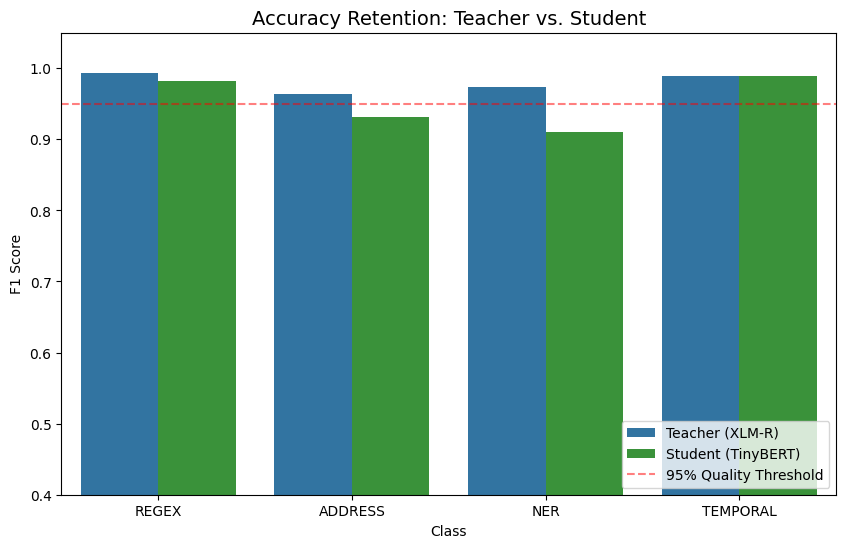

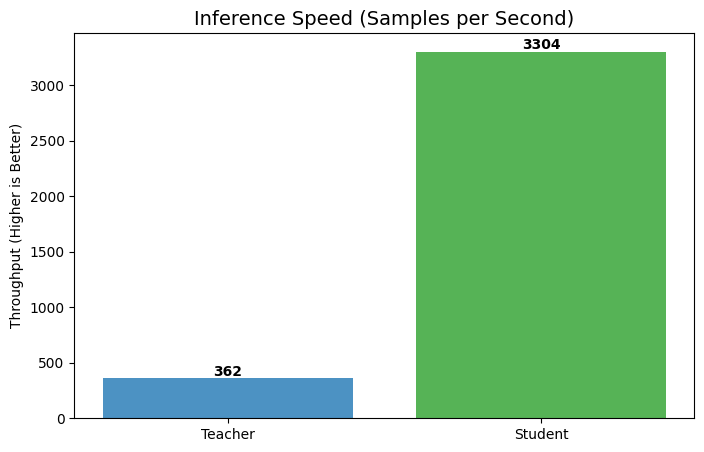

Speedup Factor: 9.1x Faster


In [34]:
df_teacher = pd.DataFrame(teacher_metrics)
df_teacher["Model"] = "Teacher (XLM-R)"
df_student = pd.DataFrame(student_metrics)
df_student["Model"] = "Student (TinyBERT)"
df_compare = pd.concat([df_teacher, df_student])

# Accuracy Comparison
plt.figure(figsize=(10, 6))
sns.barplot(data=df_compare, x="Class", y="F1", hue="Model", palette=["#1f77b4", "#2ca02c"])
plt.title("Accuracy Retention: Teacher vs. Student", fontsize=14)
plt.ylim(0.4, 1.05)
plt.ylabel("F1 Score")
plt.axhline(0.95, color='red', linestyle='--', alpha=0.5, label="95% Quality Threshold")
plt.legend(loc="lower right")
plt.show()

# Speed Comparison
plt.figure(figsize=(8, 5))
bars = plt.bar(['Teacher', 'Student'], [teacher_speed, student_speed], color=['#1f77b4', '#2ca02c'], alpha=0.8)
plt.title("Inference Speed (Samples per Second)", fontsize=14)
plt.ylabel("Throughput (Higher is Better)")
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 20, f"{int(yval)}", ha='center', fontweight='bold')
plt.show()

print(f"Speedup Factor: {student_speed / teacher_speed:.1f}x Faster")

Compare model sizes

In [37]:
def print_model_size(model, name="Model"):
    # 1. Count Total Parameters
    param_count = sum(p.numel() for p in model.parameters())
    
    # 2. Calculate Size in MB (Parameters + Buffers)
    # We sum the size of all parameters and buffers (like batch norm stats)
    param_size = sum(p.nelement() * p.element_size() for p in model.parameters())
    buffer_size = sum(b.nelement() * b.element_size() for b in model.buffers())
    total_size_mb = (param_size + buffer_size) / 1024**2
    
    print(f"{name} Size:")
    print(f"   • Parameters: {param_count:,}")
    print(f"   • Memory:     {total_size_mb:.2f} MB")
    print("-" * 30)

# Run it on both to show the contrast
print_model_size(teacher_model, "Teacher (XLM-R)")
print_model_size(student_model, "Student (TinyBERT)")

Teacher (XLM-R) Size:
   • Parameters: 278,046,724
   • Memory:     1060.67 MB
------------------------------
Student (TinyBERT) Size:
   • Parameters: 11,171,588
   • Memory:     42.62 MB
------------------------------


## Phase 6: Interactive Test
Some Hardcoded examples that were not present in the dataset

In [38]:
def run_router(text):
    probs = predict(text, student_model, student_tokenizer)
    print(f"\nInput: \"{text}\"")
    print("-" * 40)
    print(f"{'ROUTING DECISION':<20} | {'CONFIDENCE':<10}")
    print("-" * 40)
    
    active_routes = []
    for i, score in enumerate(probs):
        label = id2label[i]
        if score > 0.5:
            print(f"\033[92m✅ {label:<17} | {score:.1%}\033[0m")
            active_routes.append(label)
        else:
            print(f"\033[90m❌ {label:<17} | {score:.1%}\033[0m")
            
    action = f"Route to {', '.join(active_routes)} Engine(s)" if active_routes else "Send directly to LLM (No PII detected)"
    print(f"\nAction: {action}")

# === TEST CASES ===
run_router("Please ship the package to 123 Main St, London, UK.")
run_router("Contact support at help@company.com and John Appleseed CEO if you have issues.")
run_router("Let's meet on 12/05/2024 at 5pm in Tel Aviv")
run_router("Write me a poem about a robot learning to love.")
run_router("Schedule a meeting with John in London on Friday")


Input: "Please ship the package to 123 Main St, London, UK."
----------------------------------------
ROUTING DECISION     | CONFIDENCE
----------------------------------------
❌ REGEX             | 12.5%
✅ ADDRESS           | 98.7%
❌ NER               | 6.4%
❌ TEMPORAL          | 10.3%

Action: Route to ADDRESS Engine(s)

Input: "Contact support at help@company.com and John Appleseed CEO if you have issues."
----------------------------------------
ROUTING DECISION     | CONFIDENCE
----------------------------------------
✅ REGEX             | 98.5%
❌ ADDRESS           | 1.1%
✅ NER               | 86.9%
❌ TEMPORAL          | 2.6%

Action: Route to REGEX, NER Engine(s)

Input: "Let's meet on 12/05/2024 at 5pm in Tel Aviv"
----------------------------------------
ROUTING DECISION     | CONFIDENCE
----------------------------------------
❌ REGEX             | 35.0%
✅ ADDRESS           | 76.3%
❌ NER               | 14.9%
✅ TEMPORAL          | 98.9%

Action: Route to ADDRESS, TEMPORAL Eng